In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

In [2]:
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
import os
import sys

if os.path.abspath('../../..') not in sys.path:
    sys.path.append(os.path.abspath('../../..'))

In [4]:
MODEL_VERSION = 0

In [5]:
import json
import re
import logging
import uuid
import random

from collections import defaultdict

import tqdm

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from imblearn.under_sampling import RandomUnderSampler 

from flashtext import KeywordProcessor

from gensim.parsing.preprocessing import (
    preprocess_string, 
    strip_tags,
    strip_punctuation, 
    strip_multiple_whitespaces, 
    strip_numeric, 
    lower_to_unicode,
    strip_short,
    remove_stopwords,
)
from gensim.corpora.dictionary import Dictionary
from gensim.models import AuthorTopicModel as GensimAuthorTopicModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import temporary_file

import seaborn as sns

from src.corpus import load_documents, load_tweets, load_availability
from src.config import config
from src.plotting import bokeh as bhp

sns.set_theme()
bhp.output_notebook()

Loading BokehJS ...

In [6]:
logging.basicConfig(
    format='%(asctime)s:%(levelname)s:%(message)s', 
    level=logging.WARNING,
    handlers=[
        logging.StreamHandler(),
    ]
)

In [8]:
docs = []
for doc in load_documents(verbose=True):
    if len(doc.tokens) > 5:
        docs.append(doc)

Loading Documents: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 880682/880682 [01:31<00:00, 9586.76it/s]


In [19]:
docs_with_kw = list(filter(lambda d: d.has_keyword, docs))

print('% docs with keywords: {}'.format(len(docs_with_kw)/len(docs)))

keyword_doc_count = defaultdict(lambda: 0)

keyword_doc_count['other'] = len(docs) - len(docs_with_kw)

for doc in docs_with_kw:
    for kw in set(doc.keywords):
        keyword_doc_count[kw] += 1

print('--' * 20 + '\nKeyword Based Label Statistics\n' + '--' * 20)
print('\n'.join(map(lambda x: '{:<20s}\t{:>6d}'.format(*x), sorted(keyword_doc_count.items(), key=lambda x: x[1]))))

% docs with keywords: 0.1394387481855762
----------------------------------------
Keyword Based Label Statistics
----------------------------------------
solution            	  4029
description         	  8935
causes              	 10513
analysis            	 35313
problem             	 43240
other               	576854


In [172]:
unique_docs = []
observed_set = set()
for doc in tqdm.tqdm(docs, desc='Extracting Unique Documents'):
    doc_tokens = tuple(sorted(doc.tokens))
    if doc_tokens not in observed_set:
        unique_docs.append(doc)
        observed_set.add(doc_tokens)

print('{} duplicates removed from a total of {} documents.'.format(len(docs)-len(unique_docs), len(docs)))

labels = set()
for i, doc in enumerate(unique_docs):
    labels.update(doc.keywords)
labels = list(labels) + ['other']
label2id = dict(zip(labels, range(len(labels))))

rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X, y = [], []
    
for i, doc in enumerate(unique_docs):
    X.append([i])
    y_doc = [0 for _ in range(len(label2id))]
    label = 'other'
    if len(doc.keywords) > 0:
        label = random.choice(doc.keywords)
    y_doc[label2id[label]] = 1
    y.append(y_doc)

X = np.array(X)
y = np.array(y)

X_res, y_res = rus.fit_resample(X, y)

docs_sample = [unique_docs[x[0]] for x in tqdm.tqdm(X_res, desc='Selecting Documents')]

Extracting Unique Documents: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 670323/670323 [00:01<00:00, 467716.67it/s]


77623 duplicates removed from a total of 670323 documents.


Selecting Documents: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 87675/87675 [00:00<00:00, 1708959.45it/s]


In [173]:
np.unique(y_res, return_counts=True)

(array([0, 1]), array([438375,  87675]))

In [174]:
docs_with_kw = list(filter(lambda d: d.has_keyword, docs_sample))

print('% docs with keywords: {}'.format(len(docs_with_kw)/len(docs_sample)))

keyword_doc_count = defaultdict(lambda: 0)

keyword_doc_count['other'] = len(docs_sample) - len(docs_with_kw)

for doc in docs_with_kw:
    for kw in set(doc.keywords):
        keyword_doc_count[kw] += 1

print('--' * 20 + '\nKeyword Based Label Statistics\n' + '--' * 20)
print('\n'.join(map(lambda x: '{:<20s}\t{:>6d}'.format(*x), sorted(keyword_doc_count.items(), key=lambda x: x[1]))))

% docs with keywords: 0.9626347305389221
----------------------------------------
Keyword Based Label Statistics
----------------------------------------
other               	  3276
solution            	  3824
description         	  8362
causes              	 10111
analysis            	 28727
problem             	 41672


<AxesSubplot:ylabel='Count'>

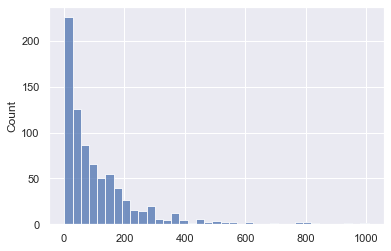

In [178]:
fig_data = [len(x) for _, x in author2doc.items()]

sns.histplot(fig_data)

In [183]:
# parameters of model
min_num_topics = len(keywords) + 1
num_topics_range = list(range(min_num_topics, 11)) + list(range(15, 51, 5))
num_epochs = 5
iterations = 10
chunksize = 2000

def progress_desc(trial, num_trials, num_topics, epoch):
    return 'Training the Model (Trial {}/{}, Topics {}, Epoch {})'.format(
        trial, num_trials, num_topics, epoch
    )

num_trials = len(num_topics_range)
for trial, num_topics in enumerate(num_topics_range):
    epoch = 1
    eta = create_eta(keywords, dictionary, num_topics, len(corpus) // 100, normalize=True)
    with temporary_file('serialized') as s_path:
        model = GensimAuthorTopicModel(
            tqdm.tqdm(corpus, desc=progress_desc(trial+1, num_trials, num_topics, epoch)),
            author2doc=author2doc, 
            passes=1,
            iterations=iterations,
            id2word=dictionary, 
            num_topics=num_topics,
            eta=eta,
            serialized=True, 
            serialization_path=s_path,
            eval_every=None,)
        model.save(get_topic_model_path(num_topics=num_topics, epoch=epoch))
        epoch += 1
        while epoch <= num_epochs:
            model.update(
                tqdm.tqdm(corpus, desc=progress_desc(trial+1, num_trials, num_topics, epoch)),
                author2doc=author2doc
            )
            model.save(get_topic_model_path(num_topics=num_topics, epoch=epoch))
            epoch += 1

Training the Model (Trial 1/13, Topics 6, Epoch 1): 100%|████████████████████████████████████████████████████████████████████████████| 87675/87675 [01:55<00:00, 759.38it/s]
Training the Model (Trial 1/13, Topics 6, Epoch 2): 100%|████████████████████████████████████████████████████████████████████████████| 87675/87675 [01:46<00:00, 826.69it/s]
Training the Model (Trial 1/13, Topics 6, Epoch 3): 100%|████████████████████████████████████████████████████████████████████████████| 87675/87675 [01:41<00:00, 862.35it/s]
Training the Model (Trial 1/13, Topics 6, Epoch 4): 100%|████████████████████████████████████████████████████████████████████████████| 87675/87675 [01:41<00:00, 861.20it/s]
Training the Model (Trial 1/13, Topics 6, Epoch 5): 100%|████████████████████████████████████████████████████████████████████████████| 87675/87675 [01:41<00:00, 862.41it/s]
Training the Model (Trial 2/13, Topics 7, Epoch 1): 100%|████████████████████████████████████████████████████████████████████████████| 

In [187]:
history = []

for trial, num_topics in tqdm.tqdm(enumerate(num_topics_range), desc='Loading Snapshots'):
    for epoch in range(1, num_epochs+1):
        local_topic_model_path = get_topic_model_path(num_topics=num_topics, epoch=epoch)
        local_topic_model = GensimAuthorTopicModel.load(local_topic_model_path)
        history.append(dict(
            num_topics=num_topics,
            epoch=epoch,
            model=local_topic_model,
        ))

In [188]:
scores = []

for history_item in tqdm.tqdm(history, desc='Evaluating Snapshots'):
    local_topic_model = history_item['model']
    u_mass = CoherenceModel(model=local_topic_model, corpus=corpus, coherence='u_mass')
    c_v = CoherenceModel(model=local_topic_model, texts=tokenized_docs, coherence='c_v')
    scores.append(dict(
        num_topics=history_item['num_topics'],
        epoch=history_item['epoch'],
        u_mass=u_mass.get_coherence(), 
        c_v=c_v.get_coherence()
    ))

Evaluating Snapshots: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [08:35<00:00,  7.93s/it]


In [189]:
pd.DataFrame(scores)

,num_topics,epoch,u_mass,c_v
0,6,1,-4.879681,0.385370
1,6,2,-4.670272,0.386020
2,6,3,-4.738684,0.392793
3,6,4,-4.455181,0.411942
4,6,5,-4.690960,0.419779
...,...,...,...,...
60,50,1,-4.965308,0.426507
61,50,2,-4.721515,0.439731
62,50,3,-4.746412,0.435768
63,50,4,-4.679986,0.438431


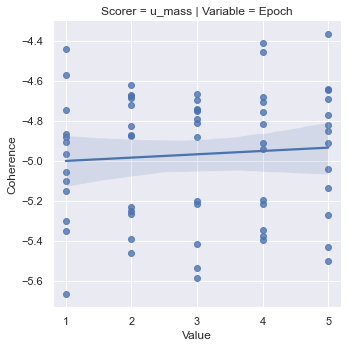

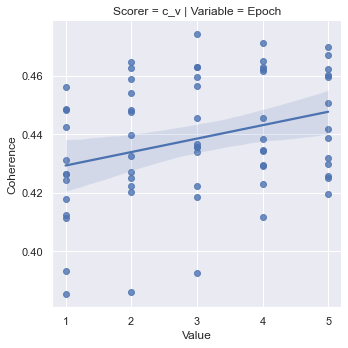

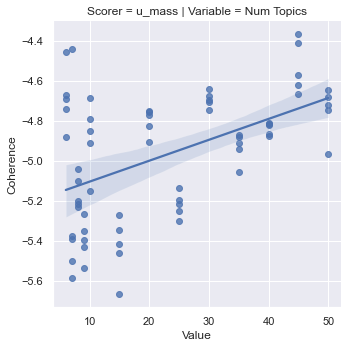

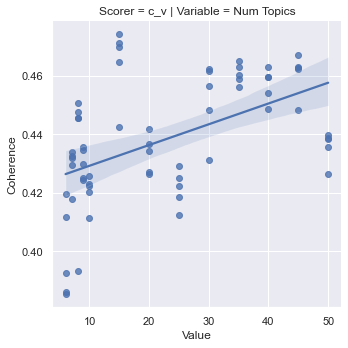

In [194]:
fig_data_1 = []
fig_data_2 = []
fig_data_3 = []
fig_data_4 = []

for i, row in enumerate(scores):
    fig_data_1.append({'Variable': 'Epoch', 'Value': row['epoch'], 'Scorer': 'u_mass', 
                     'Coherence': row['u_mass']})
    fig_data_2.append({'Variable': 'Epoch', 'Value': row['epoch'], 'Scorer': 'c_v', 
                     'Coherence': row['c_v']})
    fig_data_3.append({'Variable': 'Num Topics', 'Value': row['num_topics'], 'Scorer': 'u_mass', 
                     'Coherence': row['u_mass']})
    fig_data_4.append({'Variable': 'Num Topics', 'Value': row['num_topics'], 'Scorer': 'c_v', 
                     'Coherence': row['c_v']})

sns.lmplot(x='Value', y='Coherence', row='Scorer', col='Variable', data=pd.DataFrame(fig_data_1))
sns.lmplot(x='Value', y='Coherence', row='Scorer', col='Variable', data=pd.DataFrame(fig_data_2))
sns.lmplot(x='Value', y='Coherence', row='Scorer', col='Variable', data=pd.DataFrame(fig_data_3))
sns.lmplot(x='Value', y='Coherence', row='Scorer', col='Variable', data=pd.DataFrame(fig_data_4))

In [197]:
model = GensimAuthorTopicModel.load(get_topic_model_path(num_topics=9, epoch=5))

In [198]:
author_vecs = []

for author in model.id2author.values():
    author_topics = model.get_author_topics(author)
    author_vecs.append(author_topics)

In [199]:
# Train the model on the corpus.
for topic_id in range(model.num_topics):
    for term_id, p in model.get_topic_terms(topic_id):
        print('{:>02} {:<30s}{:0.3f}'.format(topic_id, dictionary[term_id], p))

00 tropical_storm                0.087
00 tropical                      0.042
00 forecast                      0.041
00 #SpectrumNews1KY_#kywx        0.040
00 hurricane                     0.037
00 storm                         0.033
00 heat_index                    0.023
00 #kywx                         0.019
00 #mowx                         0.014
00 #SpectrumNews1KY              0.012
01 science                       0.024
01 renewable_energy              0.023
01 amp                           0.019
01 solar                         0.018
01 new                           0.017
01 energy                        0.016
01 goes                          0.012
01 oil_gas                       0.011
01 says                          0.010
01 gas                           0.010
02 today                         0.033
02 good_morning                  0.027
02 morning                       0.026
02 forecast_today                0.025
02 forecast                      0.017
02 day                   

In [200]:
tropic_proba = []

for i in tqdm.tqdm(range(len(docs_sample))):
    tropic_proba.append(list(zip(*model.get_new_author_topics(corpus[i:i+1])))[1])
    
tropic_proba = np.array(tropic_proba)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87675/87675 [00:30<00:00, 2914.81it/s]


In [201]:
dict(zip(*np.unique(tropic_proba.argmax(axis=1), return_counts=True)))

{0: 3902,
 1: 25103,
 2: 9422,
 3: 7053,
 4: 7567,
 5: 12000,
 6: 6176,
 7: 14386,
 8: 2066}

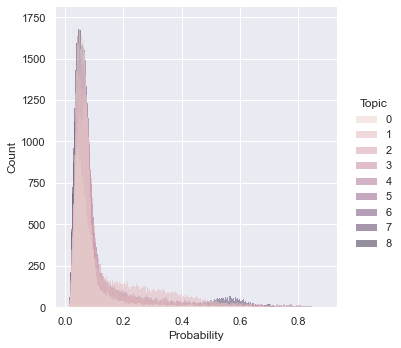

In [202]:
fig_data = [{'Topic': i, 'Probability': p} for i in range(tropic_proba.shape[1]) for p in tropic_proba[:, i]]

fig_df = pd.DataFrame(fig_data)

sns.displot(fig_df, x='Probability', hue='Topic')

In [203]:
%%time
tsne = TSNE(n_components=2, random_state=0)
smallest_author = 0  # Ignore authors with documents less than this.
authors = [model.author2id[a] for a in model.author2id.keys() if len(model.author2doc[a]) >= smallest_author]
_ = tsne.fit_transform(model.state.gamma[authors, :])  # Result stored in tsne.embedding_

x = tsne.embedding_[:, 0]
y = tsne.embedding_[:, 1]
author_names = [model.id2author[a] for a in authors]

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
author_sizes = [len(model.author2doc[a]) for a in author_names]
radii = [size * scale for size in author_sizes]

source = bhp.ColumnDataSource(
    data=dict(
        x=x,
        y=y,
        author_names=author_names,
        author_sizes=author_sizes,
        radii=radii,
    )
)

# Add author names and sizes to mouse-over info.
hover = bhp.HoverTool(
    tooltips=[
        ("author", "@author_names"),
        ("size", "@author_sizes"),
    ]
)

p = bhp.figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'])
p.scatter('x', 'y', radius='radii', source=source, fill_alpha=0.6, line_color=None)
bhp.show(p)

/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 9.21 s, sys: 85.5 ms, total: 9.3 s
Wall time: 2.53 s


In [204]:
topic_docs = defaultdict(list)

for idx, topic in enumerate(tropic_proba.argmax(axis=1)):
    proba = tropic_proba[idx, topic]
    if proba > 1/3:
        topic_docs[topic].append(docs_sample[idx])
    
topic_docs = dict(topic_docs)

In [205]:
for key, value in topic_docs.items():
    print(key, len(value))

1 13606
2 5728
3 3645
4 5315
0 2492
6 4581
5 6955
7 10096
8 1030


In [206]:
# 0 - Yes, 
# 1 - may be, heat
# 2 - No, Storm
# 3 - No, Thunderstorm
# 4 - No, Covid-19, General, Politics, Climate Change
# 5 - No, General Weather